In [1]:
from causalimpact import CausalImpact

import numpy as np
import pandas as pd
import datetime
from datetime import datetime

from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

In [3]:
from statsmodels.tsa.arima_model import ARIMA

In [4]:
import warnings
warnings.filterwarnings("ignore")

# **Data**

In [5]:
data = pd.read_csv("KOEPPEL FUNNEL.csv", parse_dates=['Date'])

In [6]:
print('Time period is: from ', data.Date.min().date(), ' to ', data.Date.max().date())

Time period is: from  2022-03-14  to  2022-10-30


In [7]:
#remove last row: totals
data = data.dropna(how='any', subset=['Date'], axis = 0)

Changing data types

In [8]:
data['tCVR'] = data['tCVR'].str.rstrip("%").astype(float)/100

data['CPT'] = data.CPT.str[1:].astype(str).astype(float)
data['CPI'] = data.CPI.str[1:].astype(str).astype(float)
data['Spend'] = data.Spend.str[1:].str.replace(',', '').astype(str).astype(float)
data['Rate'] = data.Rate.str[1:].astype(str).astype(float)

data['Frequency'] = data['Frequency'].astype(str).astype(int)

data['Trials'] = data['Trials'].astype(str).astype(int)

data['Installs'] = data['Installs'].str.replace(',', '').astype(str).astype(int)

In [9]:
data=data.sort_values(by=['Date'])
#reset indexes
data.reset_index(drop=True, inplace = True)

In [10]:
# Set pre-period
pre_period = [str(data.Date.min())[:10], str('2022-10-25')]
# Set post-period
post_period = [str('2022-10-26'), str(data.Date.max())[:10]]

# **Casual Impact model**

In [11]:
model_data=data[['Date', 'Trials']]
model_data.set_index('Date', inplace=True)

Smallest parameter prior_level_sd where difference is statistically significant is 0.07, but historical predictions are not so good. For larger values for parameter difference is not statistically significant (but historical predictions improve).

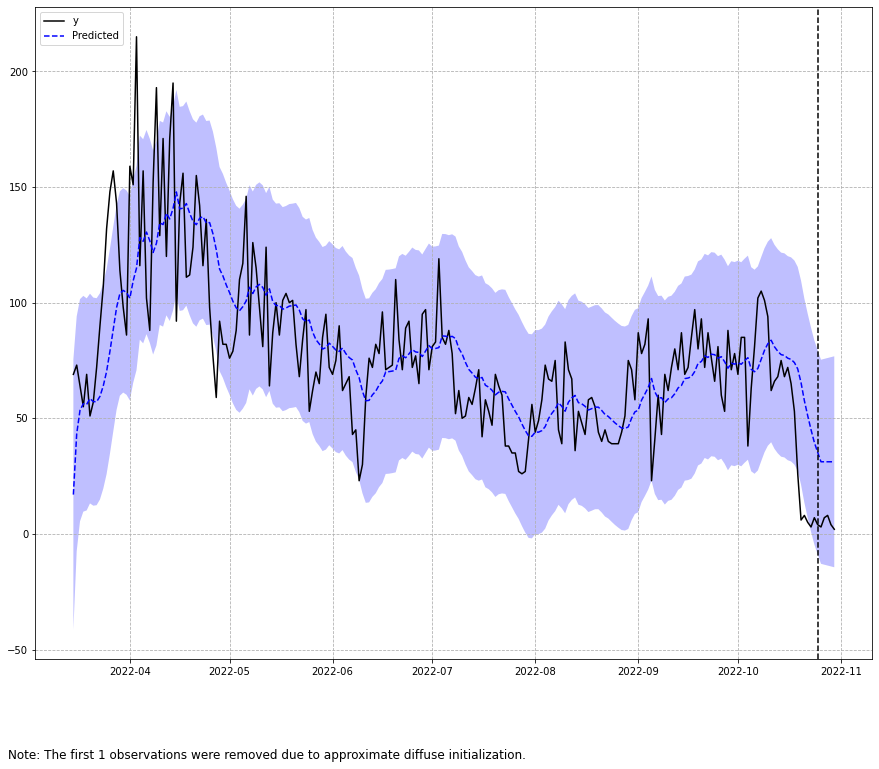

In [68]:
# Causal impact model, prior_level_sd default of 0.01
impact = CausalImpact(data=model_data.Trials, pre_period=pre_period, post_period=post_period, prior_level_sd = 0.07)
impact.plot(panels=['original'])

In [69]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 4.8. By contrast, in the absence of an
intervention, we would have expected an average response of 31.19.
The 95% interval of this counterfactual prediction is [6.84, 56.15].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -26.39 with a 95% interval of
[-51.35, -2.04]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 24.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 155.96. The 95% interval of this prediction is [34.21, 280.76].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

# **ARIMA** time series analysis

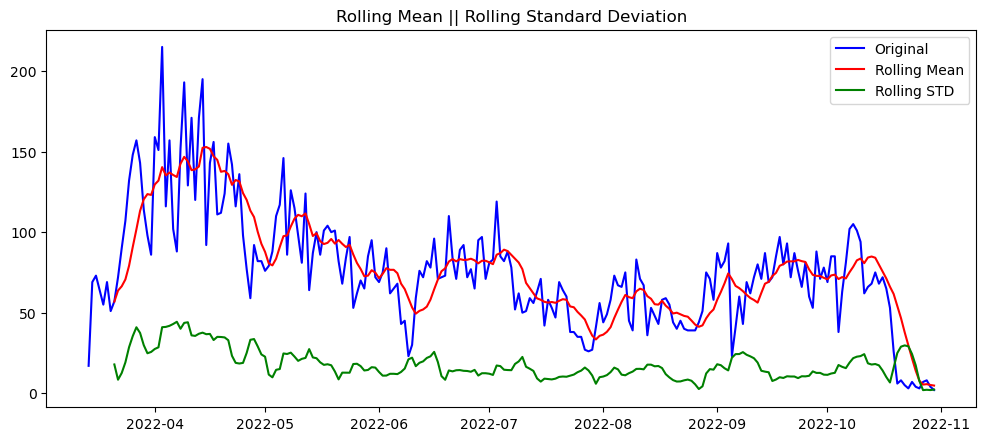

In [14]:
rolling_mean = model_data.rolling(window = 8).mean()
rolling_std = model_data.rolling(window = 8).std()

# ploting the data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

In [15]:
result = adfuller(model_data['Trials'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6803319735368305
P-Values: 0.4412734588178363
Critical Values: 
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


Time series is non stationary!

In [16]:
#in one function:

In [17]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Trials'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

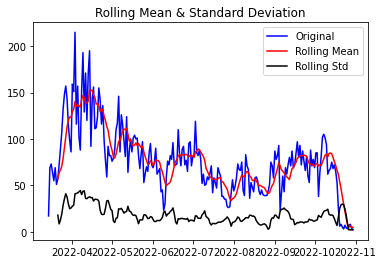

ADF Statistic: -1.6803319735368305
p-value: 0.4412734588178363
Critical Values:
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


In [18]:
get_stationarity(model_data)

In [19]:
result = adfuller(model_data['Trials'].diff().dropna())
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.185648392816719
P-Values: 6.299035106685484e-08
Critical Values: 
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


**Finding model parameters:**

Time series from 1st degree differencing is stationary!

In [20]:
from pmdarima.arima.utils import ndiffs

ndiffs(model_data['Trials'], test='adf')  #1

1

In [21]:
ndiffs(model_data['Trials'], test='kpss')  #1

1

**d=1**

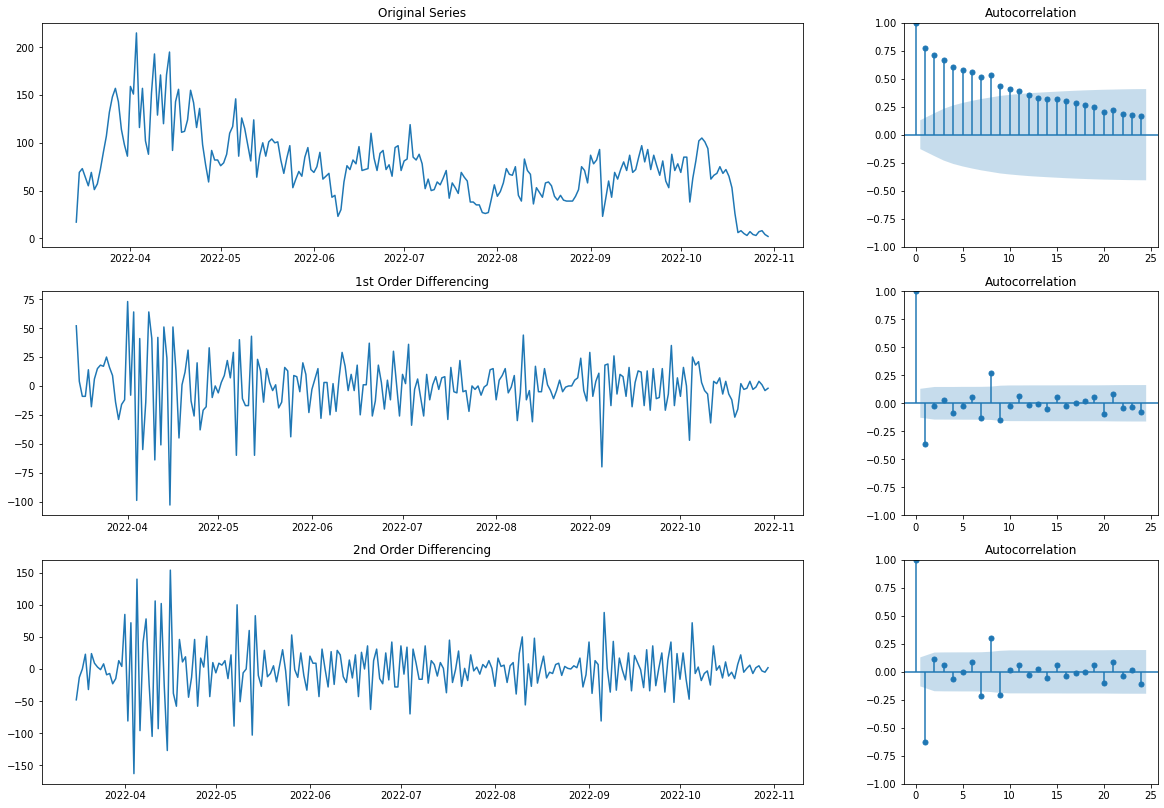

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 14))
axes[0, 0].plot(model_data['Trials']); axes[0, 0].set_title('Original Series')
plot_acf(model_data['Trials'], ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(model_data['Trials'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(model_data['Trials'].diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(model_data['Trials'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(model_data['Trials'].diff().diff().dropna(), ax=axes[2, 1])
plt.show()

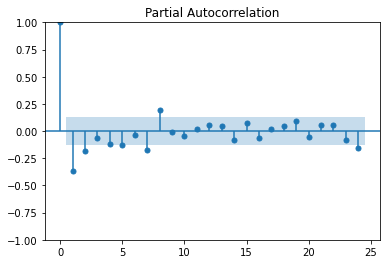

In [23]:
plot_pacf(model_data['Trials'].diff().dropna())
plt.show()

**max(p)=3** (can be set to 2 or 1)

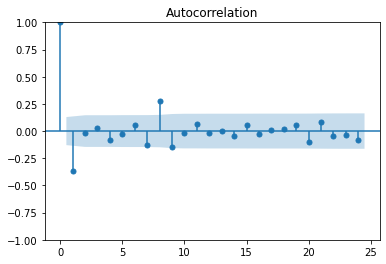

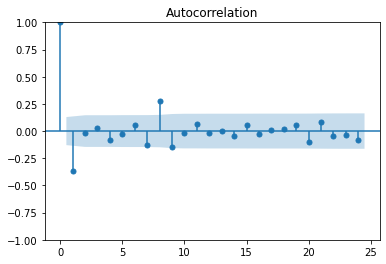

In [24]:
plot_acf(model_data['Trials'].diff().dropna()) 

**max(q)=2** (can be set to 1)

In [25]:
from  statsmodels.tsa.arima.model import ARIMA
# ARIMA order (p,d,q)
model = ARIMA(model_data['Trials'], order=(3,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  231
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1029.037
Date:                Fri, 09 Dec 2022   AIC                           2070.073
Time:                        16:17:15   BIC                           2090.702
Sample:                    03-14-2022   HQIC                          2078.394
                         - 10-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      1.197     -0.085      0.932      -2.448       2.243
ar.L2          0.1905      0.295      0.645      0.519      -0.389       0.770
ar.L3          0.0781      0.085      0.916      0.3

Train and test for pre and post period:

In [26]:
train =  model_data.loc[model_data.index <= '2022-10-25', 'Trials']

In [27]:
train.shape

(226,)

In [30]:
test = model_data.loc[model_data.index > '2022-10-25', 'Trials']

In [31]:
test.shape

(5,)

Auto-ARIMA

In [32]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2070.393, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2026.905, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2027.545, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2028.839, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2029.149, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2031.132, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2039.155, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2027.144, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2028.497, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2030.227, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2031.142, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2033.138, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2028.383, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2030.353, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2032.223, Time=0.19 sec
 ARIMA(3,1

In [36]:
prediction, confint = auto_model.predict(n_periods=5, return_conf_int=True)

prediction

2022-10-26    5.308496
2022-10-27    5.137974
2022-10-28    4.967452
2022-10-29    4.796930
2022-10-30    4.626408
Freq: D, dtype: float64

In [37]:
cf= pd.DataFrame(confint)

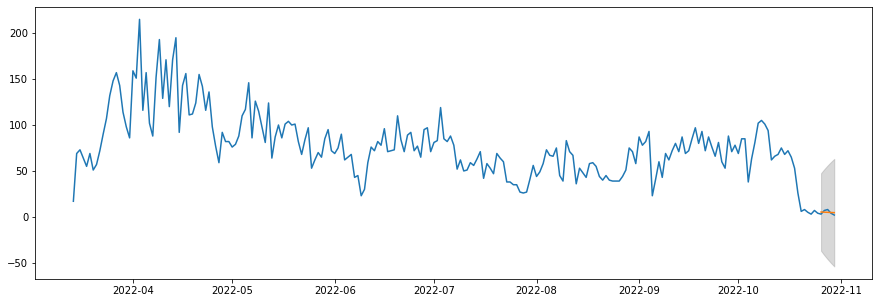

In [38]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(model_data)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

# ARIMA model

In [39]:
import numpy as np
model = ARIMA(train, order=(3,1,2))  
fitted = model.fit()

In [40]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  226
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1009.044
Date:                Fri, 09 Dec 2022   AIC                           2030.088
Time:                        16:17:45   BIC                           2050.584
Sample:                    03-14-2022   HQIC                          2038.360
                         - 10-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0888      1.167     -0.076      0.939      -2.376       2.198
ar.L2          0.1997      0.302      0.661      0.509      -0.393       0.792
ar.L3          0.0821      0.088      0.929      0.3

In [42]:
# Forecast
fc = fitted.forecast(5, alpha=0.05)

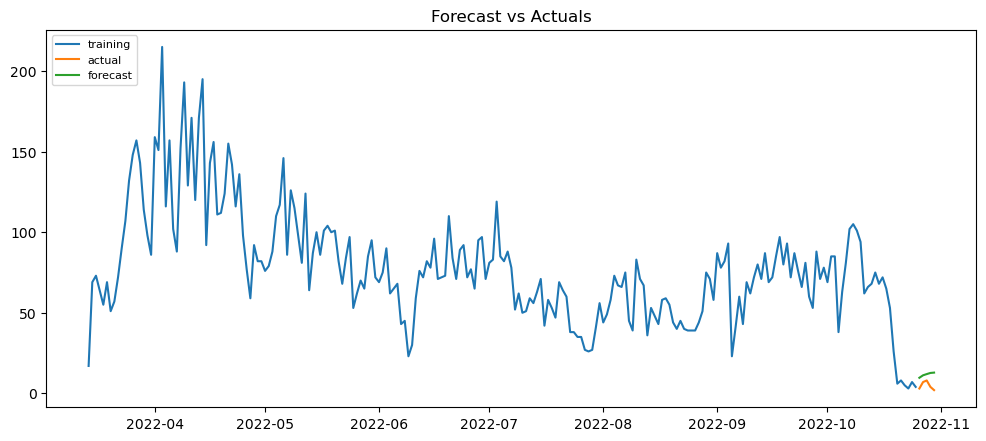

In [43]:
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

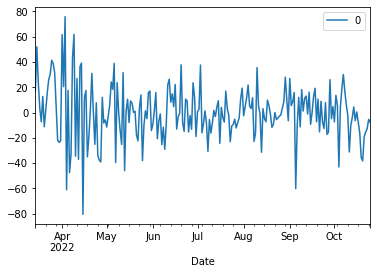

In [44]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot()
plt.show()

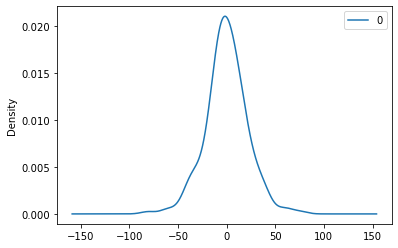

In [45]:
residuals.plot(kind='kde')
plt.show()

In [46]:
print(residuals.describe())

                0
count  226.000000
mean    -0.100302
std     21.521753
min    -80.567725
25%    -11.351310
50%      0.019115
75%     11.910194
max     75.864371


# **Casual Impact and ARIMA comparison**

Predicted Price pct change


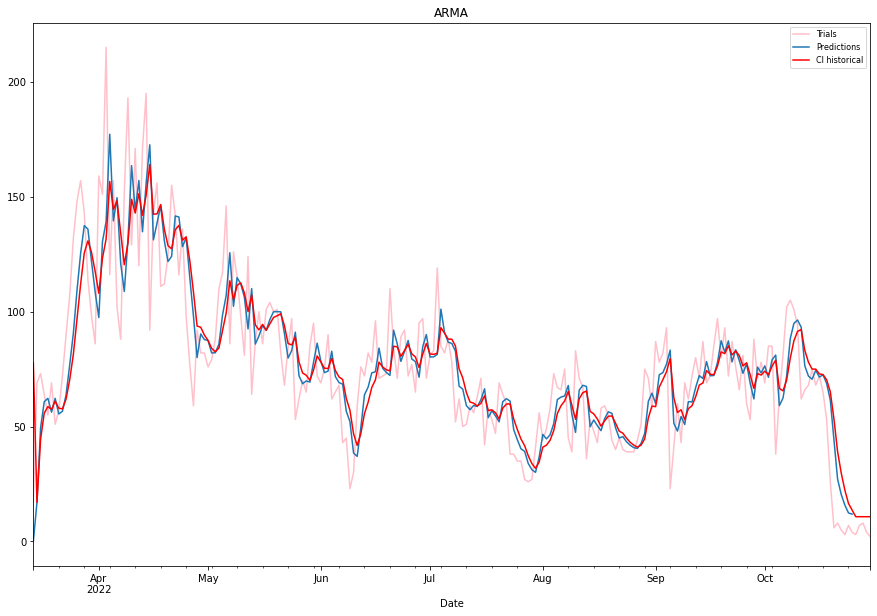

In [61]:
print("Predicted Price pct change")
def plotARMA(df_accumulative,ax, model):
    result=df_accumulative
    mod = model
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label='Trials', color = 'pink')
    res.predict().plot(ax=ax,label='Predictions')
    plt.plot(impact.inferences.preds, color = 'red', label = 'CI historical')

fig,ax = plt.subplots(figsize=(15,10))    
plotARMA(model_data['Trials'],ax, model)
plt.legend(fontsize=8)
plt.title("ARMA")
plt.show()

ARIMA predictions track Casual Impact model historical estimations

# Predictions if TV spend remains off

In [49]:
# ARIMA order (p,d,q)
model_future = ARIMA(model_data['Trials'], order=(3,1,2))
model_fit_future = model_future.fit()
print(model_fit_future.summary())

                               SARIMAX Results                                
Dep. Variable:                 Trials   No. Observations:                  231
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1029.037
Date:                Fri, 09 Dec 2022   AIC                           2070.073
Time:                        16:18:22   BIC                           2090.702
Sample:                    03-14-2022   HQIC                          2078.394
                         - 10-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      1.197     -0.085      0.932      -2.448       2.243
ar.L2          0.1905      0.295      0.645      0.519      -0.389       0.770
ar.L3          0.0781      0.085      0.916      0.3

In [50]:
fc = model_fit_future.forecast(62, alpha=0.05)

In [51]:
from datetime import date, timedelta

sdate = date(2022,10,31) 
edate = date(2023,1,1) 
forecast_index = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [52]:
len(forecast_index)

62

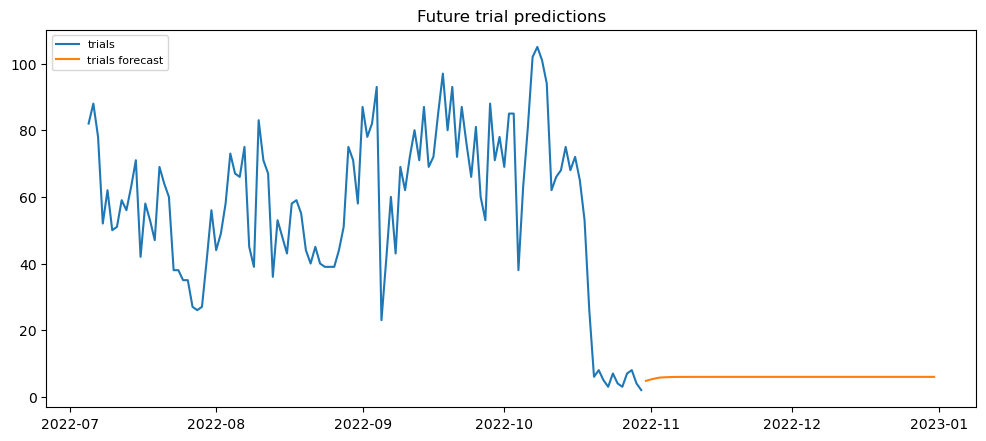

In [53]:
fc_series = pd.Series(fc,forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data.loc[model_data.index > '2022-07-04','Trials'], label='trials')
plt.plot(fc_series, label='trials forecast')
plt.title('Future trial predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

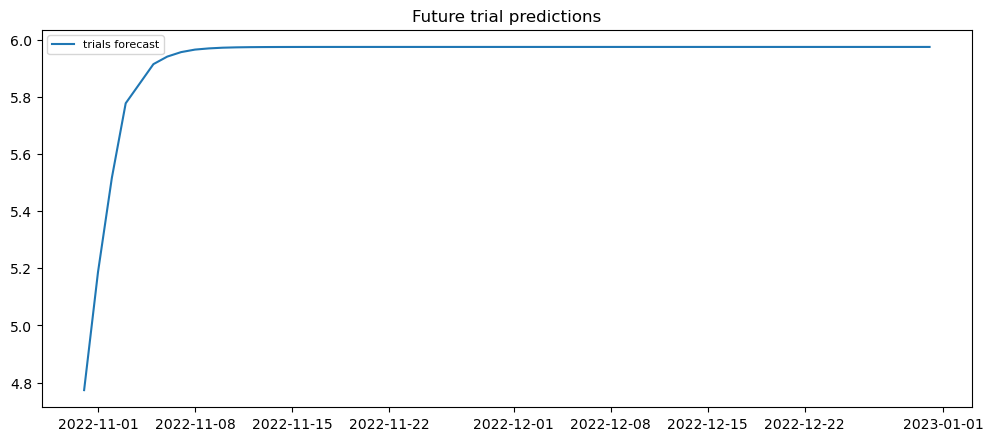

In [56]:
fc_series = pd.Series(fc,forecast_index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(model_data.loc[model_data.index > '2022-07-04','Trials'], label='trials')
plt.plot(fc_series, label='trials forecast')
plt.title('Future trial predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [57]:
fc.groupby([lambda x: x.year, lambda x: x.month]).sum()

2022  10      4.773774
      11    177.539966
      12    185.220070
Name: predicted_mean, dtype: float64

Predicted trials for November: 177\
Predicted trials for December: 185

In [58]:
model_data.groupby([lambda x: x.year, lambda x: x.month]).sum()

Trials
Date Date        
2022 3       1602
     4       3896
     5       2822
     6       2172
     7       1796
     8       1674
     9       2176
     10      1435